In [1]:
import pandas as pd
import numpy as np
import xarray as xr

In [2]:
import xarray as xr
import glob
import os

# Get list of all year directories
year_dirs = glob.glob('data/*/')

# Initialize empty list to store datasets
all_datasets = []

# Load and combine data from each year
for year_dir in year_dirs:
    # Get all daily files in this year's directory
    daily_files = glob.glob(os.path.join(year_dir, '*.nc'))
    
    # Load each daily file for this year
    year_datasets = []
    for daily_file in daily_files:
        ds = xr.open_dataset(daily_file)
        year_datasets.append(ds)
    
    # Combine all days for this year
    if year_datasets:
        year_combined = xr.concat(year_datasets, dim='time')
        all_datasets.append(year_combined)

# Combine all years into single dataset
combined_ds = xr.concat(all_datasets, dim='time')



In [3]:
# Remove duplicate timestamps by keeping first occurrence
_, unique_indices = np.unique(combined_ds.time.values, return_index=True)
combined_ds = combined_ds.isel(time=unique_indices)

In [4]:
combined_ds

<xarray.Dataset> Size: 7GB
Dimensions:     (time: 3288, y: 448, x: 304)
Coordinates:
  * time        (time) datetime64[ns] 26kB 2002-02-20 2002-02-21 ... 2022-12-31
  * y           (y) float64 4kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * x           (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
Data variables:
    F17_ICECON  (time, y, x) float64 4GB nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    crs         (time) |S1 3kB b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    F13_ICECON  (time, y, x) float64 4GB 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
Attributes: (12/49)
    title:                     Bootstrap Sea Ice Concentrations from Nimbus-7...
    summary:                   These sea ice concentration data were derived ...
    id:                        10.5067/X5LG68MH013O
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced by the NASA Cryospheri...
    metadata_link:             https://doi.org/10.5067/X5LG68MH013O
    ...                        ...
    geospatial_y_resolution:   25000.0 meters
    geospatial_lat_min:        30.980564
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    platform:                  DMSP 5D-3/F17 Defense Meteorological Satellite...

In [24]:
combined_ds.sel(time = slice(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-01-31')))

<xarray.Dataset> Size: 68MB
Dimensions:     (time: 31, y: 448, x: 304)
Coordinates:
  * time        (time) datetime64[ns] 248B 2022-01-01 2022-01-02 ... 2022-01-31
  * y           (y) float64 4kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * x           (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
Data variables:
    F17_ICECON  (time, y, x) float64 34MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    crs         (time) |S1 31B b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    F13_ICECON  (time, y, x) float64 34MB nan nan nan nan ... nan nan nan nan
Attributes: (12/49)
    title:                     Bootstrap Sea Ice Concentrations from Nimbus-7...
    summary:                   These sea ice concentration data were derived ...
    id:                        10.5067/X5LG68MH013O
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced by the NASA Cryospheri...
    metadata_link:             https://doi.org/10.5067/X5LG68MH013O
    ...                        ...
    geospatial_y_resolution:   25000.0 meters
    geospatial_lat_min:        30.980564
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    platform:                  DMSP 5D-3/F17 Defense Meteorological Satellite...

In [4]:
combined_ds.to_netcdf('data/combined_dataset.nc')


C:\Users\maxim\AppData\Local\Temp\ipykernel_54836\1753816222.py:1: SerializationWarning: saving variable F17_ICECON with floating point data as an integer dtype without any _FillValue to use for NaNs
  combined_ds.to_netcdf('data/combined_dataset.nc')
c:\Users\maxim\anaconda3\envs\tfgpu2\lib\site-packages\xarray\coding\variables.py:559: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype)
C:\Users\maxim\AppData\Local\Temp\ipykernel_54836\1753816222.py:1: SerializationWarning: saving variable F13_ICECON with floating point data as an integer dtype without any _FillValue to use for NaNs
  combined_ds.to_netcdf('data/combined_dataset.nc')


In [2]:
import pandas as pd
import numpy as np
import xarray as xr
combined_ds = xr.open_dataset('data/combined_dataset.nc')

In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
# Take first 500 timesteps of data
combined_ds_train = combined_ds.isel(time=slice(10, 500))

combined_ds_test = combined_ds.isel(time=slice(1000, 1200))

print(f"Dataset now contains {len(combined_ds.time)} timesteps")
print(f"Time range: {combined_ds.time[0].values} to {combined_ds.time[-1].values}")


Dataset now contains 3288 timesteps
Time range: 2002-02-20T00:00:00.000000000 to 2022-12-31T00:00:00.000000000


In [5]:
import torch
import torch.nn as nn

class DataGenerator:
    def __init__(self, dataset, sequence_length=10):
        self.dataset = dataset
        self.sequence_length = sequence_length
        self.total_days = len(dataset.time)
        
    def __getitem__(self, idx):
        # Ensure we have enough days left to get sequence + label
        if idx > self.total_days - (self.sequence_length + 1):
            idx = np.random.randint(0, self.total_days - (self.sequence_length + 1))
            
        # Get sequence of 10 consecutive days
        sequence = self.dataset.isel(time=slice(idx, idx + self.sequence_length))
        
        # Get the 11th day as label
        label = self.dataset.isel(time=idx + self.sequence_length)
        
        # Convert to numpy arrays and select F17_ICECON variable
        X = sequence.F17_ICECON.values
        y = label.F17_ICECON.values
        
        # Add channel dimension for ConvLSTM (batch, time, channel, height, width)
        X = np.expand_dims(X, axis=1)
        y = np.expand_dims(y, axis=0)
        
        return torch.FloatTensor(X), torch.FloatTensor(y)
    
    def __len__(self):
        return self.total_days - (self.sequence_length + 1)
    
    def get_random_sample(self):
        idx = np.random.randint(0, len(self))
        return self[idx]

# Create data generator instances and DataLoaders for train and test
train_generator = DataGenerator(combined_ds_train)
test_generator = DataGenerator(combined_ds_test)

batch_size = 8
train_loader = torch.utils.data.DataLoader(
    train_generator,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test_generator,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

# Example of getting a batch from DataLoader
# X, y = train_generator.get_random_sample()
# print(f"Input sequence shape: {X.shape}")  # Should be (10, 1, 448, 304)
# print(f"Target shape: {y.shape}")         # Should be (1, 448, 304)


In [5]:
class ConvLSTM2d(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM2d, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]
            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                        hidden_dim=self.hidden_dim[i],
                                        kernel_size=self.kernel_size[i],
                                        bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                               cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                            out_channels=4 * self.hidden_dim,
                            kernel_size=self.kernel_size,
                            padding=self.padding,
                            bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)

        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


In [10]:
import torch.nn as nn



class ConvLSTM(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=32, kernel_size=3):
        super(ConvLSTM, self).__init__()
        
        self.convlstm = ConvLSTM2d(
            input_dim=input_channels,
            hidden_dim=hidden_channels,
            kernel_size=(kernel_size, kernel_size),
            num_layers=2,
            batch_first=True,
            bias=True,
            return_all_layers=False
        )
        
        self.conv_out = nn.Conv2d(hidden_channels, 1, kernel_size=1)
        
    def forward(self, x):
        # x shape: (batch, time, channel, height, width)
        output, _ = self.convlstm(x)
        last_output = output[0][:, -1]  # Take last time step
        pred = self.conv_out(last_output)
        return pred

# Initialize model, optimizer and loss function
model = ConvLSTM().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 50


NameError: name 'ConvLSTM2d' is not defined

In [6]:
class ChainedConvModel(nn.Module):
    def __init__(self):
        super(ChainedConvModel, self).__init__()
        
        # Chain of convolutions that preserve dimensions using padding
        self.conv_chain = nn.Sequential(
            nn.Conv2d(10, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # Input shape: (batch, time, channel, height, width)
        # Since channel is always 1, we can merge time and channel dimensions
        batch_size = x.size(0)
        x = x.squeeze(2)  # Remove channel dimension since it's always 1
        
        # Process input through conv chain
        # Shape is now (batch, time, height, width)
        out = self.conv_chain(x)
        return out

# Initialize alternative model
model = ChainedConvModel().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = nn.MSELoss()

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 377,153 trainable parameters


In [8]:
torch.cuda.empty_cache()

In [9]:
for epoch in range(1):
    model.train()
    running_loss = 0.0
    
    for batch_X, batch_y in tqdm(train_loader):
        batch_X = batch_X.cuda()
        batch_y = batch_y.cuda()
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print epoch statistics
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')


model.eval()
with torch.no_grad():
    test_X, test_y = next(iter(test_loader))
    test_X = test_X.cuda()
    test_y = test_y.cuda()
    
    prediction = model(test_X)
    test_loss = criterion(prediction, test_y)
    print(f'Test Loss: {test_loss.item():.4f}')


 20%|██        | 12/60 [00:55<03:40,  4.60s/it]


KeyboardInterrupt: 

In [9]:
torch.save(model.state_dict(), 'convlstm_model.pth')

In [8]:
model.load_state_dict(torch.load('convlstm_model.pth'))
model.eval()

C:\Users\maxim\AppData\Local\Temp\ipykernel_28844\2253854189.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('convlstm_model.pth'))


ConvLSTM(
  (convlstm): ConvLSTM2d(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(33, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (conv_out): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [9]:
torch.cuda.empty_cache()


In [8]:
test_X, test_y = next(iter(test_loader))

In [11]:
test_X.shape

torch.Size([1, 10, 1, 448, 304])

In [12]:
prediction = model(test_X.cuda())

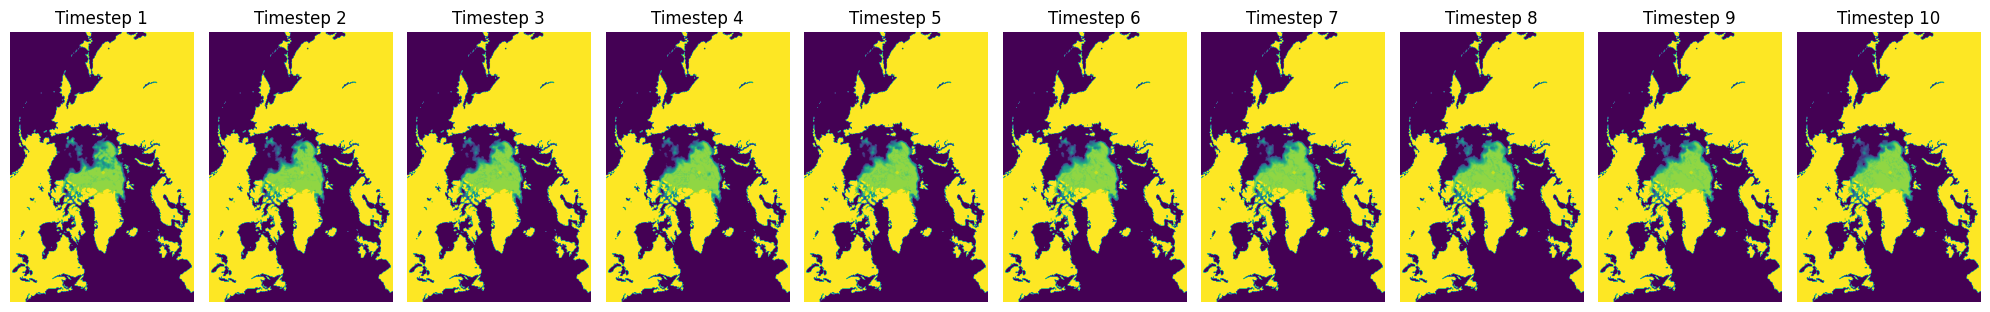

In [19]:
# Create a figure with subplots in a single row
fig, axes = plt.subplots(1, test_X.shape[1], figsize=(20, 4))

# Plot each timestep from test_X
for i in range(test_X.shape[1]):
    axes[i].imshow(test_X[0,i,0].numpy())
    axes[i].set_title(f'Timestep {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


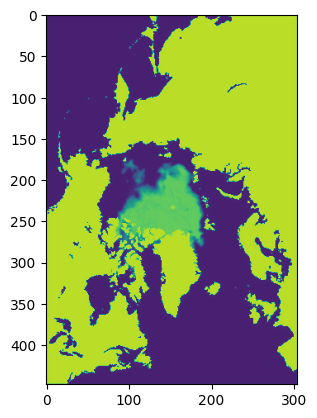

In [18]:
plt.imshow(prediction[0][0].cpu().detach().numpy())

In [21]:
start_idx

0

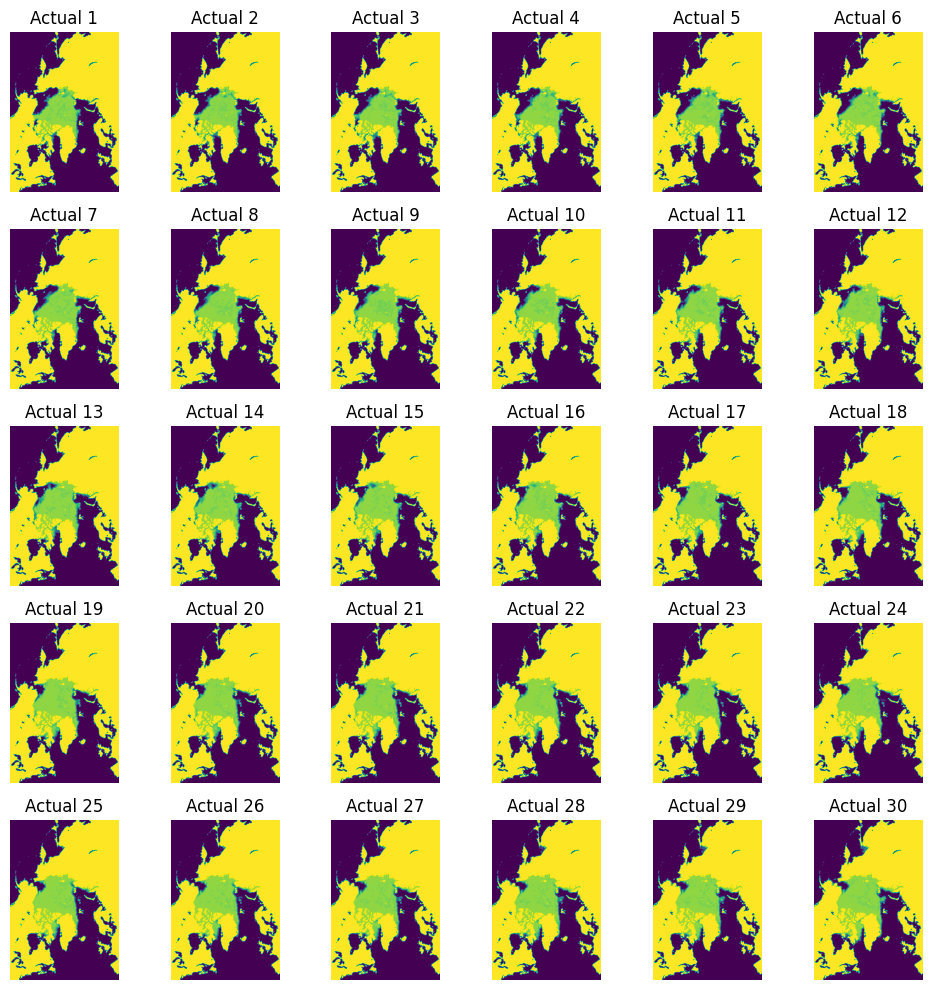

In [10]:
# Get the actual values from combined_ds_test for comparison
# Assuming test_X contains data starting from a specific date
# Get the next 30 timesteps after that date

# Find the starting date from test_X
start_idx = 50
start_date = combined_ds_test.time[start_idx].values

# Get the next 30 days of actual data
actual_sequence = combined_ds_test.F17_ICECON.sel(
    time=slice(start_date, start_date + np.timedelta64(30, 'D'))
).values

# Reshape to match prediction format
actual_sequence = actual_sequence.reshape(-1, 1, actual_sequence.shape[1], actual_sequence.shape[2])

# Visualize actual sequence
fig, axes = plt.subplots(5, 6, figsize=(10, 10))
axes = axes.flatten()
for i in range(30):
    axes[i].imshow(actual_sequence[i,0])
    axes[i].set_title(f'Actual {i+1}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()



In [23]:
type(actual_sequence)

numpy.ndarray

In [11]:
test_X = torch.tensor(actual_sequence[:10])


In [12]:
test_X = test_X.unsqueeze(0).float()


In [27]:
test_X_rolling.shape

torch.Size([1, 10, 1, 448, 304])

In [13]:
# Initialize test_X_rolling with the initial test_X
test_X_rolling = test_X.cuda()

predictions_sequence = []

# Run the model 30 times, each time using previous prediction as new input
for i in range(5):
    print(i)
    # Get prediction from model
    current_pred = model(test_X_rolling)
    
    # Store prediction
    predictions_sequence.append(current_pred.detach())
    
    # Remove first timestep and append prediction to end
    test_X_rolling = test_X_rolling[:, 1:, :, :, :]
    test_X_rolling = torch.cat([
        test_X_rolling,
        current_pred.unsqueeze(1)
    ], dim=1)
    torch.cuda.empty_cache()


0
1
2
3
4


OutOfMemoryError: CUDA out of memory. Tried to allocate 68.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 12.03 GiB is allocated by PyTorch, and 597.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

IndexError: index 4 is out of bounds for dimension 1 with size 4

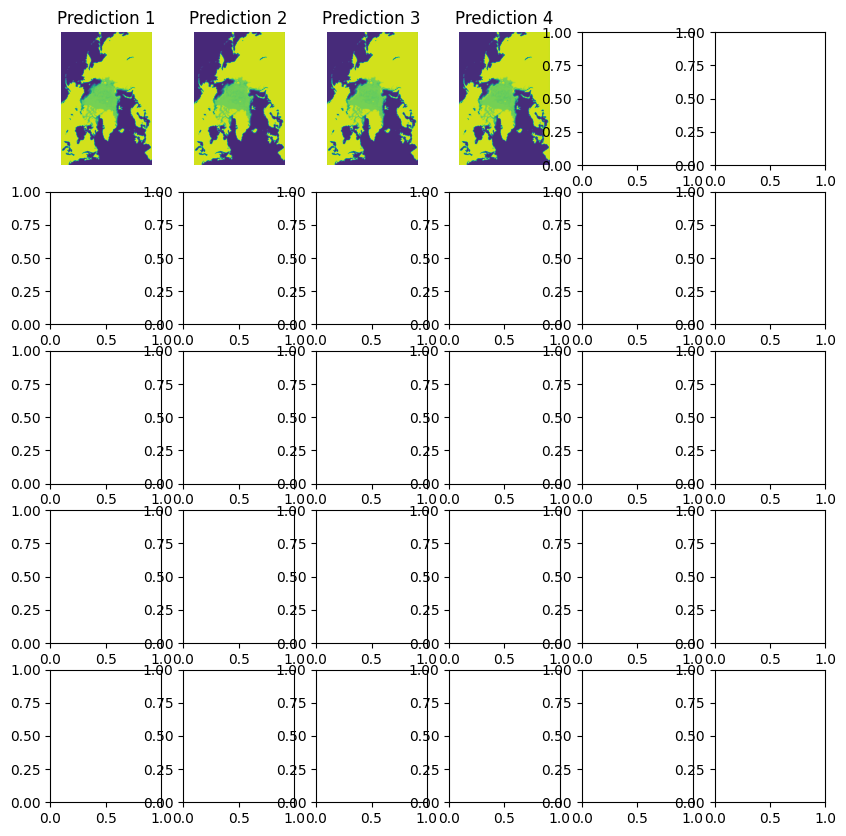

In [21]:

# Stack all predictions into single tensor
# predictions_sequence = torch.cat(predictions_sequence, dim=1)

# Visualize the sequence
fig, axes = plt.subplots(5, 6, figsize=(10, 10))
axes = axes.flatten()
for i in range(30):
    axes[i].imshow(predictions_sequence[0,i].cpu().numpy())
    axes[i].set_title(f'Prediction {i+1}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


In [19]:
predictions_sequence.shape

torch.Size([1, 4, 448, 304])

In [37]:
torch.cuda.empty_cache()